In [3]:
import numpy as np
import struct
import glob
import sys
import os

from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
directory = r"C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\\"
filenames = glob.glob(os.path.join(directory, '*.dat'))
#print(filenames)

In [12]:
with open(filename, 'rb') as f:
    data = f.read()
    print(type(data), len(data))

<class 'bytes'> 1811688


In [13]:
#for i in range(4):
#    print(i, struct.unpack('<4I', data[i:16+i]))
print(struct.unpack('>4I', data[8:16+8]))

(730712, 75905028, 6, 3273548713)


In [14]:
class Rae2File:
    def __init__(self, filename):
        with open(filename, 'rb') as f:
            self.raw_data = f.read()  # skip first junk bytes
        self.offset = 0

    def read_date(self):
        #self.offset += 4
        #i = self.offset
        date = struct.unpack('>I', self.raw_data[self.offset:self.offset+4])
        self.offset += 4
        return date
        
    def read_block(self):
        #i = self.offset
        assert len(self.raw_data[self.offset:]) > 4 * 28
        ms, fq_band = struct.unpack('>II', self.raw_data[self.offset:self.offset+8])
        self.offset += 8
        rdata = np.array(struct.unpack('>26I', self.raw_data[self.offset:self.offset+4*26]))
        
        # IBM 32-bit floating point format
        # https://nssdc.gsfc.nasa.gov/nssdc/formats/IBM_32-Bit.html
        rdata_sign = rdata // 2**31
        rdata_exp = rdata % 2**31 // 2**24
        rdata_frac = rdata % 2**24
        fdata = (-1)**rdata_sign * 16.**(rdata_exp - 64) * (rdata_frac / 2**24)
        self.offset += 4 * 26
        return ms, fq_band, fdata

    def read_logical_record(self, cnt=8):
        #self.offset = self.block_start
        self.offset += 4
        date = self.read_date()
        blocks = []
        for i in range(cnt):
            blocks.append(self.read_block())
        temp = self.read_temp()
        return date, blocks, temp
        
    def read_temp(self):
        temp = struct.unpack('>I', self.raw_data[self.offset:self.offset+4])
        self.offset += 4
        return temp

    def read_physical_record(self, cnt=35):
        self.offset += 4
        assert len(self.raw_data) > self.offset
        data = []
        for i in range(cnt):
            data.append(self.read_logical_record())
        return data

    def read_file(self):
        data = []
        while True:
            try:
                data.append(self.read_physical_record())
            except(AssertionError):
                break
        return data

In [15]:
f = Rae2File(filename)

In [16]:
data = f.read_file()
print(len(data))
#hex(73)
#hex(730615)

57


In [29]:

def Rae2Pandas(data):

  times = []
  position = []
  frequency_bands = []
  earth_unit_vector = []
  right_ascension = []
  declination = []
  rv1_coarse = []
  rv1_fine = []
  rv2_coarse = []
  rv2_fine = []
  rv_temps = []

  for physical_record in data:
    for logical_record in physical_record:
      yymmdd_int = logical_record[0][0]
      yymmdd = datetime.strptime(str(yymmdd_int), '%y%m%d')
      rv_temp = logical_record[-1][0]
      for block in logical_record[1]:
          milliseconds, frequency_band, fdata = block
          t0 = yymmdd + timedelta(milliseconds=milliseconds)

          if True: #fdata[0] > 0:

            tstep = 15.4 / 8

            t_record = [t0 + timedelta(seconds = tstep * i) for i in range(8)]

            for i, t in enumerate(t_record):

              times.append(t)
              frequency_bands.append(frequency_band)
            
              if i == 0:
                position.append(fdata[0:3])
                earth_unit_vector.append(fdata[3:6])
                right_ascension.append(fdata[6])
                declination.append(fdata[7])
                rv1_coarse.append(np.nan)
                rv2_coarse.append(np.nan)
                rv_temps.append(rv_temp)
              else:
                position.append([np.nan,np.nan,np.nan])
                earth_unit_vector.append([np.nan,np.nan,np.nan])
                right_ascension.append(np.nan)
                declination.append(np.nan)
                rv1_coarse.append(fdata[i+7])
                rv2_coarse.append(fdata[i+16])
                rv_temps.append(rv_temp)

              if i == 0:
                rv1_fine.append(fdata[15])
                rv2_fine.append(fdata[24])
              elif i == 4:
                rv1_fine.append(fdata[16])
                rv2_fine.append(fdata[25])
              else:
                rv1_fine.append(np.nan)
                rv2_fine.append(np.nan)

  position = np.stack(position, axis=0)
  earth_unit_vector = np.stack(earth_unit_vector, axis=0)

  df = pd.DataFrame({'time': times, 
                   'frequency_band': frequency_bands,
                   'position_x': position[:,0], 
                   'position_y': position[:,1],
                   'position_z': position[:,2],
                   'earth_unit_vector_x': earth_unit_vector[:,0],
                   'earth_unit_vector_y': earth_unit_vector[:,1],
                   'earth_unit_vector_z': earth_unit_vector[:,2],
                   'right_ascension': right_ascension,
                   'declination': declination,
                   'rv1_coarse': rv1_coarse,
                   'rv2_coarse': rv2_coarse,
                   'rv1_fine': rv1_fine,
                   'rv2_fine': rv2_fine,
                   'rv_temp': rv_temps})
  df.set_index('time', inplace=True)

  cols = ["rv1_coarse","rv2_coarse","rv1_fine","rv2_fine"]
  df[cols] = df[cols].replace({'0':np.nan, 0:np.nan})

  return df

In [30]:
for filename in filenames:
  print(filename)
  if os.stat(filename).st_size > 0:
    f = Rae2File(filename)
    data = f.read_file()
    df = Rae2Pandas(data)
    df.to_csv(filename.replace('.DAT','.csv'))

C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_001.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_002.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_003.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_004.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_005.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_006.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_007.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_008.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_009.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_010.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_011.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_012.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_013.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4293_014.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\

C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_033.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_034.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_035.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_036.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_037.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_038.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_039.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_040.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_041.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_042.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_043.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_044.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_045.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\FILE_DS4294_046.DAT
C:\Users\adamf\Documents\PhD\Diffraction\RV-DAT\

In [31]:
df.keys()
#df['time'] = pd.to_datetime(df['time'])

Index(['frequency_band', 'position_x', 'position_y', 'position_z',
       'earth_unit_vector_x', 'earth_unit_vector_y', 'earth_unit_vector_z',
       'right_ascension', 'declination', 'rv1_coarse', 'rv2_coarse',
       'rv1_fine', 'rv2_fine', 'rv_temp'],
      dtype='object')

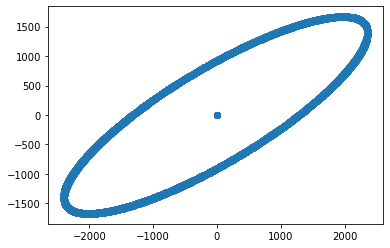

In [32]:
plt.scatter(df['position_y'],df['position_x'])

In [28]:
df

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp
time,,,,,,,,,,,,,,
1975-06-24 11:26:05.164,5,729.354492,2030.489502,1728.117676,-0.199828,0.920941,0.334568,4.048776,34.038696,NaN,NaN,1.361735e+06,1206054.0,1092322590
1975-06-24 11:26:07.089,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.410053e+06,1257525.0,NaN,NaN,1092322590
1975-06-24 11:26:09.014,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.343072e+06,1296819.0,NaN,NaN,1092322590
1975-06-24 11:26:10.939,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.343072e+06,1219418.0,NaN,NaN,1092322590
1975-06-24 11:26:12.864,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.376153e+06,1219418.0,1.361735e+06,1206054.0,1092322590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975-06-28 00:46:37.813,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.138814e+05,1106005.0,NaN,NaN,1092616191
1975-06-28 00:46:39.738,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.731011e+05,1241948.0,4.216167e+05,90245024.0,1092616191
1975-06-28 00:46:41.663,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.138814e+05,1106005.0,NaN,NaN,1092616191


array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

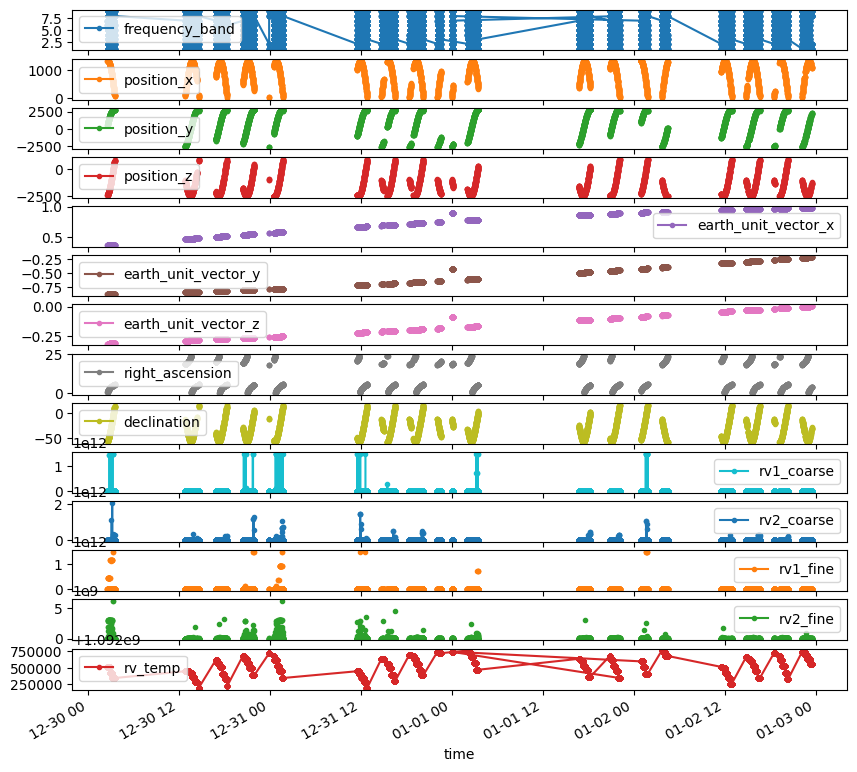

In [57]:
df.plot(subplots=True, figsize=(10, 10), marker = '.')

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

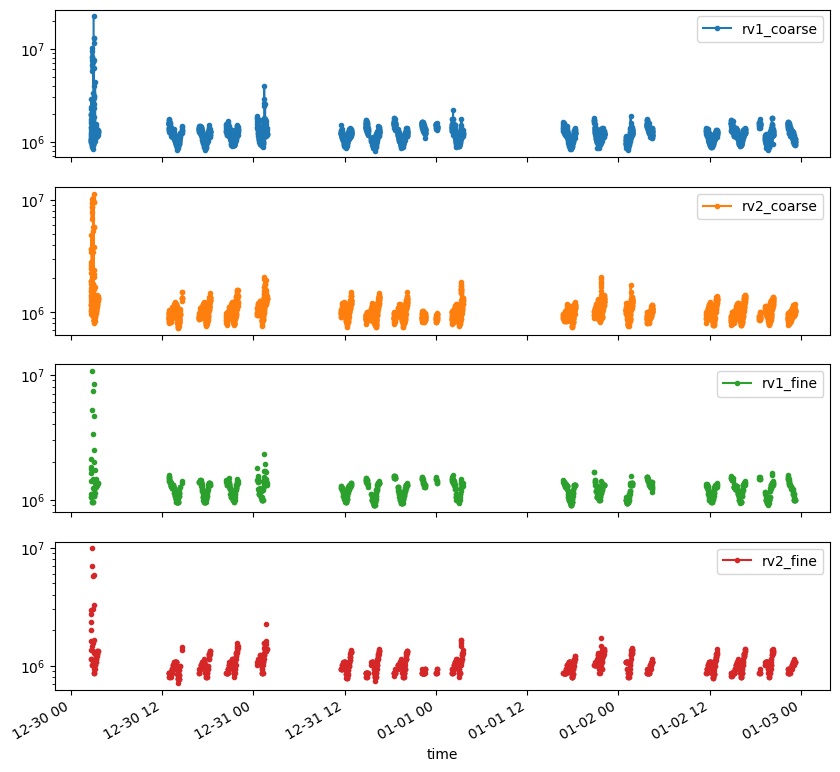

In [58]:
df2 = df.loc[df['frequency_band'] == 5]
df2[['rv1_coarse','rv2_coarse','rv1_fine','rv2_fine']].plot(subplots=True, figsize=(10, 10), marker = '.', logy=True)